### Import Packages

In [1]:
import collections
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import random
import time
import xgboost as xgb

### File Paths (config_fp...)

In [2]:
config_fp_raw_data_dir = 'D:/insurance_data/'
config_fp_raw_train_file = 'train.csv'
config_fp_raw_test_file = 'test.csv'
config_fp_proc_data_dir = 'D:/processed_insurance_data/'

### Define Functions and Classes

In [3]:
def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')


def common_list_values(list_one, list_two):
    """
    Return a list of unique values shared by two lists
    Args:
        list_one (list): first list of values
        list_two (list): second list of values
    """
    return list(set(list_one).intersection(list_two))


def actual_vs_pred_deciles(actual, predicted):
    """
    Calculate average predicted vs. actual loss for every
    decile of actual loss values. Returns a pandas DataFrame
    with columns 'Actual_Decile', 'Actual_Value', 'Predicted_Value'
    Args:
        actual : actual values
        predicted : predicted values
    """
    actual_deciles = [ad for ad in pd.qcut(actual, 10, labels = False)]
    output_df = pd.DataFrame({'Actual_Decile' : actual_deciles,
                              'Actual_Value' : actual,
                              'Predicted_Value' : predicted}).\
    groupby(['Actual_Decile'], as_index = False).\
    agg({'Actual_Value' : 'mean',
         'Predicted_Value' : 'mean'})
    return output_df


def create_partition_column(pandas_df, identifier_col, n_partitions = 10, partition_colname = 'partition'):
    """
    Add a partition column to a pandas DataFrame that ensures identifiers only occur in a single fold
    Args:
        pandas_df (pandas.DataFrame): DataFrame object to modify
        identifier_col (str): existing column with identifiers (e.g. policy number)
        n_partitions (int): number of partitions to create
        partition_colname (str): new column name to create
    """
    unique_ids = list(set(pandas_df[identifier_col]))
    random.shuffle(unique_ids)
    unique_partitions = list(range(1, n_partitions + 1, 1))
    partitions = unique_partitions * int(np.ceil(len(unique_ids) / len(unique_partitions)))
    id_partition_dict = dict(zip(unique_ids, partitions[:len(unique_ids)]))
    print(f'Creating field {partition_colname} with {n_partitions} partitions')
    pandas_df[partition_colname] = [id_partition_dict.get(x) for x in pandas_df[identifier_col]]
    

def recode_sparse_values(lst, min_freq = 0.01, recode_value = 'RECODE'):
    """
    Recode values in iterable object below some percentage frequency
    Args:
        lst (list): ... or other iterable object
        min_freq (float): minimum percentage frequency to not be recoded
        recode_value (str): string to replace values below specified frequency
    Returns:
        list
    """
    key_values = collections.Counter(lst).keys()
    percent_count_values = [v / len(lst) for v in collections.Counter(lst).values()]
    keep_values = [kv for i, kv in enumerate(key_values) if percent_count_values[i] > min_freq]
    return_values = [x if x in keep_values else recode_value for x in lst]
    return return_values


class TrainTestTransformer:
    def __init__(self,
                 df_train, df_test, y_col, categ_cols, cont_cols,
                 categ_min_freq = 0.01, categ_recode_value = 'RECODE'):
        self.df_train = df_train
        self.df_test = df_test
        self.y_col = y_col
        self.categ_cols = categ_cols
        self.cont_cols = cont_cols
        self.categ_min_freq = categ_min_freq
        self.categ_recode_value = categ_recode_value
        
    def recode_sparse_categoricals(self):
        temp_train_categ_df = pd.DataFrame()
        temp_test_categ_df = pd.DataFrame()
        for c in self.categ_cols:
            temp_train_categ_df[c] = recode_sparse_values(self.df_train[c],
                                                          min_freq = self.categ_min_freq,
                                                          recode_value = self.categ_recode_value)
            train_vals = set(list(temp_train_categ_df[c]))
            temp_test_categ_df[c] = [v if v in train_vals else self.categ_recode_value for v in self.df_test[c]]
            
        return temp_train_categ_df, temp_test_categ_df[temp_train_categ_df.columns]
        
    def label_encode_categoricals(self):
        recoded_train_categ_df, recoded_test_categ_df = self.recode_sparse_categoricals()
        dummy_train = pd.get_dummies(recoded_train_categ_df)
        dummy_test = pd.get_dummies(recoded_test_categ_df)
        common_cols = common_list_values(dummy_train.columns, dummy_test.columns)
        return dummy_train[common_cols], dummy_test[common_cols]
    
    def scale_continuous_fields(self):
        temp_train_contin_df = pd.DataFrame()
        temp_test_contin_df = pd.DataFrame()
        for c in self.cont_cols:
            train_mean = np.mean(self.df_train[c])
            train_stdev = np.std(self.df_train[c])
            temp_train_contin_df[c] = [(x - train_mean) / train_stdev if not np.isnan(x) else 0 for x in self.df_train[c]]
            temp_test_contin_df[c] = [(x - train_mean) / train_stdev if not np.isnan(x) else 0 for x in self.df_test[c]]
        return temp_train_contin_df, temp_test_contin_df
    
    def transform_train_test_xcols(self):
        cont_train, cont_test = self.scale_continuous_fields()
        categ_train, categ_test = self.label_encode_categoricals()
        xy_cols = [self.y_col] + self.categ_cols + self.cont_cols
        non_xy_cols = [c for c in self.df_train.columns if c not in xy_cols]
        train_x = pd.concat([cont_train, categ_train], axis = 1)
        test_x = pd.concat([cont_test, categ_test], axis = 1)
        return train_x, test_x

### Read Data and Define Columns

##### Read Dataset

In [4]:
loss_cost_df = pd.read_csv(f'{config_fp_raw_data_dir}{config_fp_raw_train_file}')

##### List of Categorical, Continuous, and Dependent Fields

In [5]:
categ_x_cols = [c for c in loss_cost_df.columns if 'cat' in c.lower()]
cont_x_cols = [c for c in loss_cost_df.columns if 'cont' in c.lower()]
y_col = 'loss'
partition_col = 'partition'
id_col = 'id'

### Apply Transformations After Splitting Train and Test

##### Create 10-fold Partitions

In [6]:
create_partition_column(loss_cost_df, 'id')

Creating field partition with 10 partitions


##### Apply Transformations to Train and Test

In [7]:
transformer = TrainTestTransformer(df_train = loss_cost_df[loss_cost_df.partition < 8],
                                   df_test = loss_cost_df[loss_cost_df.partition >= 8],
                                   y_col = y_col,
                                   categ_cols = categ_x_cols,
                                   cont_cols = cont_x_cols,
                                   categ_min_freq = 0.05)

train_x, test_x = transformer.transform_train_test_xcols()

##### Create Train and Test 'Y' and Identifier DataFrames

In [8]:
train_y = loss_cost_df[loss_cost_df.partition < 8][[y_col]]
test_y = loss_cost_df[loss_cost_df.partition >= 8][[y_col]]
train_id = loss_cost_df[loss_cost_df.partition < 8][[id_col]]

##### Split Training Set into Train and Validation (for early stopping)

In [9]:
train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(train_x, train_y, test_size = 0.2, random_state = 11092020)

### Fit XGBoost Model on Training Set with Early Stopping

##### Initial Hyperparameters

In [10]:
param_dict = {'objective' : 'reg:tweedie',
              'eta' : 0.03,
              'min_child_weight' : 8,
              'subsample' : 0.7,
              'colsample_bytree' : 0.6,
              'max_depth' : 6,
              'early_stopping_rounds' : 15,
              'stopping_metric' : 'gini'}

##### Create XGBoost DMatrix Objects and Validation Set Watchlist

In [11]:
dat_train = xgb.DMatrix(train_x, label = train_y)
dat_valid = xgb.DMatrix(valid_x, label = valid_y)
watchlist = [(dat_train, 'train'), (dat_valid, 'valid')]

xgb_trn = xgb.train(params = param_dict,
                    dtrain = dat_train,
                    num_boost_round = 5000,
                    evals = watchlist,
                    early_stopping_rounds = 12,
                    verbose_eval = False)

[16:27:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_master\src\learner.cc:537: 
Parameters: { early_stopping_rounds, stopping_metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




### Predict on Test Set and Evaluate Results

In [12]:
pred = xgb_trn.predict(xgb.DMatrix(test_x))

##### Create Mean Actual vs. Predicted Numbers

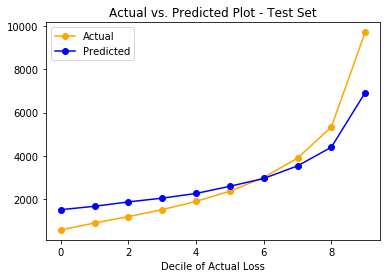

In [13]:
avp_df = actual_vs_pred_deciles(actual = test_y[y_col], predicted = pred)

plt.plot(avp_df['Actual_Decile'], avp_df['Actual_Value'], color = 'orange', label = 'Actual', marker = 'o')
plt.plot(avp_df['Actual_Decile'], avp_df['Predicted_Value'], color = 'blue', label = 'Predicted', marker = 'o')
plt.xlabel('Decile of Actual Loss')
plt.title('Actual vs. Predicted Plot - Test Set')
plt.legend()
plt.show()